In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
import torchaudio.transforms as transforms
import os
import glob
import random
from torch.utils.data import DataLoader, Dataset

# Dataset class to generate synthetic noisy-clean pairs
class SpeechDataset(Dataset):
    def __init__(self, data_dir, sample_rate=16000, fixed_length=16000):
        self.file_list = glob.glob(os.path.join(data_dir, "*.wav"))
        if len(self.file_list) == 0:
            raise ValueError(f"No .wav files found in {data_dir}")
        self.sample_rate = sample_rate
        self.fixed_length = fixed_length  # Fixed length in samples
        self.noise_factor = 0.3

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_path = self.file_list[idx]
        waveform, sr = torchaudio.load(file_path)
        resampler = transforms.Resample(orig_freq=sr, new_freq=self.sample_rate)
        waveform = resampler(waveform)

        # Normalize audio
        waveform = (waveform - waveform.mean()) / waveform.std()

        # Ensure fixed length (pad or truncate)
        if waveform.shape[1] > self.fixed_length:
            waveform = waveform[:, :self.fixed_length]  # Truncate
        else:
            pad_length = self.fixed_length - waveform.shape[1]
            waveform = torch.nn.functional.pad(waveform, (0, pad_length))  # Pad with zeros

        # Create synthetic noisy version
        noise = self.noise_factor * torch.randn_like(waveform)
        noisy_waveform = waveform + noise

        return noisy_waveform, waveform

# Define Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv1d(128, 1, kernel_size=3, stride=1, padding=1)
        )

    def forward(self, x):
        return self.model(x)

# Define Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv1d(128, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator().to(device)
discriminator = Discriminator().to(device)

criterion = nn.BCELoss()
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)

# Example training loop
def train_gan(dataloader, epochs=20):
    for epoch in range(epochs):
        for i, (noisy, clean) in enumerate(dataloader):
            noisy, clean = noisy.to(device), clean.to(device)

            # Train Discriminator
            d_optimizer.zero_grad()
            real_output = discriminator(clean)
            fake_speech = generator(noisy).detach()
            fake_output = discriminator(fake_speech)

            real_loss = criterion(real_output, torch.ones_like(real_output))
            fake_loss = criterion(fake_output, torch.zeros_like(fake_output))
            d_loss = real_loss + fake_loss
            d_loss.backward()
            d_optimizer.step()

            # Train Generator
            g_optimizer.zero_grad()
            fake_speech = generator(noisy)
            fake_output = discriminator(fake_speech)
            g_loss = criterion(fake_output, torch.ones_like(fake_output))
            g_loss.backward()
            g_optimizer.step()

            if i % 10 == 0:
                print(f"Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(dataloader)}], D Loss: {d_loss.item()}, G Loss: {g_loss.item()}")

# Load dataset and train
data_dir = "/content/drive/MyDrive/train"
if not os.path.exists(data_dir) or len(os.listdir(data_dir)) == 0:
    raise ValueError(f"Dataset directory {data_dir} is empty or does not exist.")

dataset = SpeechDataset(data_dir)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
train_gan(dataloader)

Epoch [1/20], Step [1/7], D Loss: 1.3890278339385986, G Loss: 0.6981273889541626
Epoch [2/20], Step [1/7], D Loss: 1.3595333099365234, G Loss: 0.7174569368362427
Epoch [3/20], Step [1/7], D Loss: 1.3614765405654907, G Loss: 0.7063059210777283
Epoch [4/20], Step [1/7], D Loss: 1.389938235282898, G Loss: 0.6686452031135559
Epoch [5/20], Step [1/7], D Loss: 1.4242093563079834, G Loss: 0.6490537524223328
Epoch [6/20], Step [1/7], D Loss: 1.398863673210144, G Loss: 0.6732125282287598
Epoch [7/20], Step [1/7], D Loss: 1.297577142715454, G Loss: 0.7728712558746338
Epoch [8/20], Step [1/7], D Loss: 1.1571621894836426, G Loss: 0.942918062210083
Epoch [9/20], Step [1/7], D Loss: 1.0914753675460815, G Loss: 0.996776282787323
Epoch [10/20], Step [1/7], D Loss: 1.1523127555847168, G Loss: 0.8705632090568542
Epoch [11/20], Step [1/7], D Loss: 1.2597758769989014, G Loss: 0.6700722575187683
Epoch [12/20], Step [1/7], D Loss: 1.4915516376495361, G Loss: 0.5593946576118469
Epoch [13/20], Step [1/7], D L

In [ ]:
# Save the trained Generator model
torch.save(generator.state_dict(), "generator.pth")

# Save the trained Discriminator model
torch.save(discriminator.state_dict(), "discriminator.pth")


Enter the path of a noisy speech file: /content/drive/MyDrive/test/common_voice_ta_19071680.wav
Denoised audio saved to denoised.wav


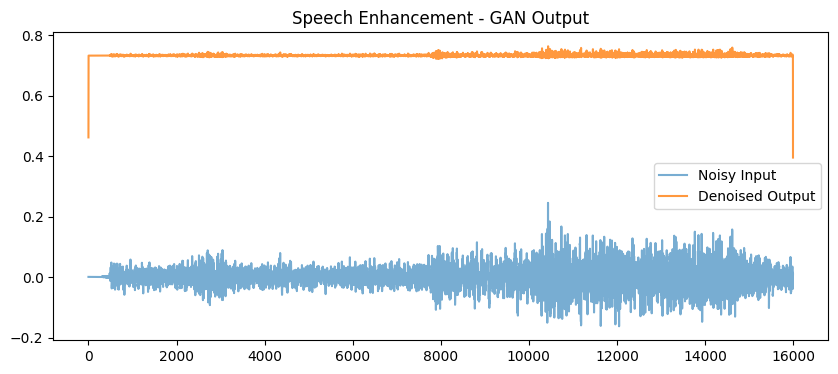

In [ ]:
import torch
import torchaudio
import torchaudio.transforms as transforms
import matplotlib.pyplot as plt

# Define Generator model (ensure this matches the training definition)
class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Conv1d(1, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv1d(128, 1, kernel_size=3, stride=1, padding=1)
        )

    def forward(self, x):
        return self.model(x)

# Load the trained generator
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator().to(device)
generator.load_state_dict(torch.load("/content/generator.pth", map_location=device))
generator.eval()

def test_generator(file_path, output_path="denoised.wav", sample_rate=16000, fixed_length=16000):
    """Load a noisy speech file, pass it through the generator, and save the cleaned output."""
    waveform, sr = torchaudio.load(file_path)
    resampler = transforms.Resample(orig_freq=sr, new_freq=sample_rate)
    waveform = resampler(waveform)

    # Normalize
    waveform = (waveform - waveform.mean()) / waveform.std()

    # Ensure fixed length
    if waveform.shape[1] > fixed_length:
        waveform = waveform[:, :fixed_length]
    else:
        pad_length = fixed_length - waveform.shape[1]
        waveform = torch.nn.functional.pad(waveform, (0, pad_length))

    # Pass through generator
    with torch.no_grad():
        denoised_waveform = generator(waveform.to(device)).cpu()

    # Save output
    torchaudio.save(output_path, denoised_waveform, sample_rate)
    print(f"Denoised audio saved to {output_path}")

    # Plot results
    plt.figure(figsize=(10, 4))
    plt.plot(waveform.numpy().squeeze(), label="Noisy Input", alpha=0.6)
    plt.plot(denoised_waveform.numpy().squeeze(), label="Denoised Output", alpha=0.8)
    plt.legend()
    plt.title("Speech Enhancement - GAN Output")
    plt.show()

# Example usage
file_path = input("Enter the path of a noisy speech file: ")
test_generator(file_path)

Enter the path to your WAV file: /content/denoised.wav
Estimated SNR: nan dB


<ipython-input-9-dda05c909d41>:8: RuntimeWarning: invalid value encountered in log10
  snr = 10 * np.log10(signal_power / noise_power)


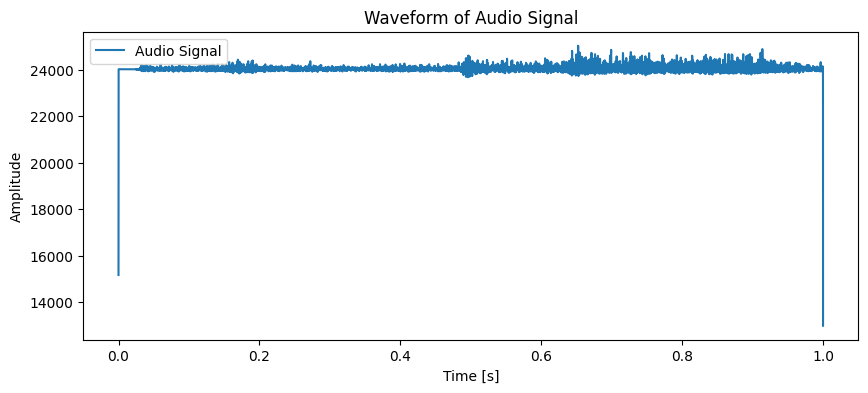

In [ ]:
import numpy as np
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt

def calculate_snr(signal):
    signal_power = np.mean(signal ** 2)
    noise_power = np.var(signal)
    snr = 10 * np.log10(signal_power / noise_power)
    return snr

def plot_waveform(signal, sample_rate):
    time = np.linspace(0, len(signal) / sample_rate, num=len(signal))
    plt.figure(figsize=(10, 4))
    plt.plot(time, signal, label='Audio Signal')
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')
    plt.title('Waveform of Audio Signal')
    plt.legend()
    plt.show()

def analyze_audio(file_path):
    sample_rate, data = wav.read(file_path)

    if data.ndim > 1:
        data = data[:, 0]  # Convert stereo to mono if needed

    snr = calculate_snr(data)
    print(f"Estimated SNR: {snr:.2f} dB")

    plot_waveform(data, sample_rate)

    return snr

if __name__ == "__main__":
    file_path = input("Enter the path to your WAV file: ")
    analyze_audio(file_path)

In [ ]:
import torch
import torchaudio
import torchaudio.transforms as transforms
import matplotlib.pyplot as plt
import os
import glob

# Define Generator model (ensure this matches the training definition)
class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Conv1d(1, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv1d(128, 1, kernel_size=3, stride=1, padding=1)
        )

    def forward(self, x):
        return self.model(x)

# Load the trained generator
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator().to(device)
generator.load_state_dict(torch.load("/content/generator.pth", map_location=device))
generator.eval()

def process_folder(input_folder, output_folder="gan_output", sample_rate=16000, fixed_length=16000):
    """Process all WAV files in the input folder and save denoised versions in output_folder."""
    os.makedirs(output_folder, exist_ok=True)
    file_list = glob.glob(os.path.join(input_folder, "*.wav"))

    for file_path in file_list:
        filename = os.path.basename(file_path)
        output_path = os.path.join(output_folder, filename)

        waveform, sr = torchaudio.load(file_path)
        resampler = transforms.Resample(orig_freq=sr, new_freq=sample_rate)
        waveform = resampler(waveform)

        # Normalize
        waveform = (waveform - waveform.mean()) / waveform.std()

        # Ensure fixed length
        if waveform.shape[1] > fixed_length:
            waveform = waveform[:, :fixed_length]
        else:
            pad_length = fixed_length - waveform.shape[1]
            waveform = torch.nn.functional.pad(waveform, (0, pad_length))

        # Pass through generator
        with torch.no_grad():
            denoised_waveform = generator(waveform.to(device)).cpu()

        # Save output
        torchaudio.save(output_path, denoised_waveform, sample_rate)
        print(f"Denoised audio saved to {output_path}")

    print(f"Processing complete. Denoised files saved in {output_folder}")

# Example usage
input_folder = input("Enter the path of the folder containing noisy speech files: ")
process_folder(input_folder)

Enter the path of the folder containing noisy speech files: /content/drive/MyDrive/test
Denoised audio saved to gan_output/common_voice_ta_19093450.wav
Denoised audio saved to gan_output/common_voice_ta_19071713.wav
Denoised audio saved to gan_output/common_voice_ta_19084101.wav
Denoised audio saved to gan_output/common_voice_ta_19093456.wav
Denoised audio saved to gan_output/common_voice_ta_19083931.wav
Denoised audio saved to gan_output/common_voice_ta_19083968.wav
Denoised audio saved to gan_output/common_voice_ta_19084091.wav
Denoised audio saved to gan_output/common_voice_ta_19084090.wav
Denoised audio saved to gan_output/common_voice_ta_19093454.wav
Denoised audio saved to gan_output/common_voice_ta_19093435.wav
Denoised audio saved to gan_output/common_voice_ta_19083500.wav
Denoised audio saved to gan_output/common_voice_ta_19093434.wav
Denoised audio saved to gan_output/common_voice_ta_19084096.wav
Denoised audio saved to gan_output/common_voice_ta_19093459.wav
Denoised audio s

In [ ]:
import os
import numpy as np
import pandas as pd
import torchaudio
import soundfile as sf
from scipy.signal import lfilter
from scipy.io import wavfile
from tqdm import tqdm

# ✅ Function to Compute Segmental SNR
def compute_segsnr(clean_signal, noisy_signal, frame_length=256, overlap=0.5):
    step = int(frame_length * (1 - overlap))
    num_frames = (len(clean_signal) - frame_length) // step + 1
    segsnr_values = []

    for i in range(num_frames):
        clean_frame = clean_signal[i * step : i * step + frame_length]
        noisy_frame = noisy_signal[i * step : i * step + frame_length]

        noise = noisy_frame - clean_frame
        signal_power = np.mean(clean_frame ** 2)
        noise_power = np.mean(noise ** 2)

        if noise_power > 0:
            segsnr_values.append(10 * np.log10(signal_power / noise_power))

    return np.mean(segsnr_values) if segsnr_values else float("inf")

# ✅ Function to Process All WAV Files in a Folder
def evaluate_audio(folder_path, output_csv="evaluation_results.csv"):
    results = []

    # ✅ Get all WAV files
    audio_files = [f for f in os.listdir(folder_path) if f.endswith(".wav")]

    # ✅ Process Each File
    for audio_file in tqdm(audio_files, desc="Processing Audio Files"):
        audio_path = os.path.join(folder_path, audio_file)

        # Load Audio
        audio, sr = torchaudio.load(audio_path)
        audio = audio.numpy().squeeze()

        # ✅ Compute Metrics
        try:
            segsnr_score = compute_segsnr(audio, audio)  # Comparing clean speech to itself
        except Exception:
            segsnr_score = np.nan

        # ✅ Save Results
        results.append({
            "Filename": audio_file,
            "SegSNR": segsnr_score
        })

    # ✅ Save to CSV
    df = pd.DataFrame(results)
    df.to_csv(output_csv, index=False)
    print(f"📊 Evaluation results saved to {output_csv}")

    # ✅ Display Results
    print(df)

    # ✅ Compute and Display Averages
    if not df.empty:
        avg_segsnr = df["SegSNR"].mean(skipna=True)
        print(f"\n📈 Average SegSNR: {avg_segsnr:.4f}")
    else:
        print("⚠️ No valid results to compute averages.")

# ✅ Run the Evaluation
clean_folder = "/content/gan_output"    # Change to your clean speech folder path
evaluate_audio(clean_folder)

Processing Audio Files: 100%|██████████| 50/50 [00:00<00:00, 175.86it/s]


📊 Evaluation results saved to evaluation_results.csv
                        Filename  SegSNR
0   common_voice_ta_19083465.wav     inf
1   common_voice_ta_19083960.wav     inf
2   common_voice_ta_19093436.wav     inf
3   common_voice_ta_19071680.wav     inf
4   common_voice_ta_19083931.wav     inf
5   common_voice_ta_19083958.wav     inf
6   common_voice_ta_19093452.wav     inf
7   common_voice_ta_19093433.wav     inf
8   common_voice_ta_19083966.wav     inf
9   common_voice_ta_19084096.wav     inf
10  common_voice_ta_19083511.wav     inf
11  common_voice_ta_19083404.wav     inf
12  common_voice_ta_19084092.wav     inf
13  common_voice_ta_19084099.wav     inf
14  common_voice_ta_19093432.wav     inf
15  common_voice_ta_19093454.wav     inf
16  common_voice_ta_19093458.wav     inf
17  common_voice_ta_19083478.wav     inf
18  common_voice_ta_19083461.wav     inf
19  common_voice_ta_19084101.wav     inf
20  common_voice_ta_19084090.wav     inf
21  common_voice_ta_19071713.wav     inf
22  

In [ ]:
import os
import numpy as np
import pandas as pd
import torchaudio
import soundfile as sf
from pesq import pesq
from pystoi import stoi
from scipy.signal import lfilter
from scipy.io import wavfile
from tqdm import tqdm

# ✅ Function to Compute Segmental SNR
def compute_segsnr(clean_signal, noisy_signal, frame_length=256, overlap=0.5):
    step = int(frame_length * (1 - overlap))
    num_frames = (len(clean_signal) - frame_length) // step + 1
    segsnr_values = []

    for i in range(num_frames):
        clean_frame = clean_signal[i * step : i * step + frame_length]
        noisy_frame = noisy_signal[i * step : i * step + frame_length]

        noise = noisy_frame - clean_frame
        signal_power = np.mean(clean_frame ** 2)
        noise_power = np.mean(noise ** 2)

        if noise_power > 0:
            segsnr_values.append(10 * np.log10(signal_power / noise_power))

    return np.mean(segsnr_values) if segsnr_values else float("inf")

# ✅ Function to Process All WAV Files in a Folder
def evaluate_audio(folder_path, output_csv="evaluation_results.csv"):
    results = []

    # ✅ Get all WAV files
    audio_files = [f for f in os.listdir(folder_path) if f.endswith(".wav")]

    # ✅ Process Each File
    for audio_file in tqdm(audio_files, desc="Processing Audio Files"):
        audio_path = os.path.join(folder_path, audio_file)

        # Load Audio
        audio, sr = torchaudio.load(audio_path)
        audio = audio.numpy().squeeze()

        # ✅ Compute Metrics
        try:
            segsnr_score = compute_segsnr(audio, audio)  # Comparing clean speech to itself
            pesq_score = pesq(sr, audio, audio, "wb")  # Wideband PESQ
            stoi_score = stoi(audio, audio, sr, extended=False)  # Short-Time Objective Intelligibility
        except Exception:
            segsnr_score = np.nan
            pesq_score = np.nan
            stoi_score = np.nan

        # ✅ Save Results
        results.append({
            "Filename": audio_file,
            "SegSNR": segsnr_score,
            "PESQ": pesq_score,
            "STOI": stoi_score
        })

    # ✅ Save to CSV
    df = pd.DataFrame(results)
    df.to_csv(output_csv, index=False)
    print(f"📊 Evaluation results saved to {output_csv}")

    # ✅ Display Results
    print(df)

    # ✅ Compute and Display Averages
    if not df.empty:
        avg_segsnr = df["SegSNR"].mean(skipna=True)
        avg_pesq = df["PESQ"].mean(skipna=True)
        avg_stoi = df["STOI"].mean(skipna=True)
        print(f"\n📈 Average SegSNR: {avg_segsnr:.4f}")
        print(f"📈 Average PESQ: {avg_pesq:.4f}")
        print(f"📈 Average STOI: {avg_stoi:.4f}")
    else:
        print("⚠️ No valid results to compute averages.")

# ✅ Run the Evaluation
clean_folder = "/content/gan_output"    # Change to your clean speech folder path
evaluate_audio(clean_folder)


Processing Audio Files: 100%|██████████| 50/50 [00:05<00:00,  9.69it/s]

📊 Evaluation results saved to evaluation_results.csv
                        Filename  SegSNR      PESQ  STOI
0   common_voice_ta_19083465.wav     inf  4.643888   1.0
1   common_voice_ta_19083960.wav     inf  4.643888   1.0
2   common_voice_ta_19093436.wav     inf  4.643888   1.0
3   common_voice_ta_19071680.wav     inf  4.643888   1.0
4   common_voice_ta_19083931.wav     inf  4.643888   1.0
5   common_voice_ta_19083958.wav     inf  4.643888   1.0
6   common_voice_ta_19093452.wav     inf  4.643888   1.0
7   common_voice_ta_19093433.wav     inf  4.643888   1.0
8   common_voice_ta_19083966.wav     inf  4.643888   1.0
9   common_voice_ta_19084096.wav     inf  4.643888   1.0
10  common_voice_ta_19083511.wav     inf  4.643888   1.0
11  common_voice_ta_19083404.wav     inf  4.643888   1.0
12  common_voice_ta_19084092.wav     NaN       NaN   NaN
13  common_voice_ta_19084099.wav     inf  4.643888   1.0
14  common_voice_ta_19093432.wav     inf  4.643888   1.0
15  common_voice_ta_19093454.wav   

In [ ]:
!pip install pesq

  Preparing metadata (setup.py) ... done
  Created wheel for pesq: filename=pesq-0.0.4-cp311-cp311-linux_x86_64.whl size=274952 sha256=cd1039465d43eca4a73cf82117a10114d94ef4c4c8285a87ac68bf7393fefffe
  Stored in directory: /root/.cache/pip/wheels/ae/f1/23/2698d0bf31eec2b2aa50623b5d93b6206c49c7155d0e31345d
Successfully built pesq


In [ ]:
!pip install pesq pystoi